In [10]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

GT_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/'
reconstruction_ZF_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/ZeroFilled/reconstructions/'
reconstruction_ZF_noACS_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/ZeroFilledNoACS/reconstructions/'
reconstruction_grappa_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/Grappa/reconstructions/'
reconstruction_sense_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/Sense/reconstructions/'
reconstruction_CS_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/CS/reconstructions/'
reconstruction_ZF_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/BaselineUNet/Epoch47/reconstructions_regularized/'
reconstruction_grappa_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/GrappaUNet/Epoch48/reconstructions_regularized/'
reconstruction_sense_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/SenseUNet/Epoch48/reconstructions/'
reconstruction_cs_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/CSUNet/Epoch49/reconstructions/'

file = 'file_brain_AXFLAIR_200_6002527.h5'  # R = 4 (global 49th-51st percentile)
file = 'file_brain_AXT1PRE_210_6001641.h5'  # R = 8 (global 49th-51st percentile)

GT_path = os.path.join(GT_path,file)
reconstruction_ZF_path = os.path.join(reconstruction_ZF_path,file)
reconstruction_ZF_noACS_path = os.path.join(reconstruction_ZF_noACS_path,file)
reconstruction_grappa_path = os.path.join(reconstruction_grappa_path,file)
reconstruction_sense_path = os.path.join(reconstruction_sense_path,file)
reconstruction_CS_path = os.path.join(reconstruction_CS_path,file)
reconstruction_ZF_unet_path = os.path.join(reconstruction_ZF_unet_path,file)
reconstruction_grappa_unet_path = os.path.join(reconstruction_grappa_unet_path,file)
reconstruction_sense_unet_path = os.path.join(reconstruction_sense_unet_path,file)
reconstruction_cs_unet_path = os.path.join(reconstruction_cs_unet_path,file)

GT = h5py.File(GT_path, 'r')
reconstruction_ZF = h5py.File(reconstruction_ZF_path, 'r')
reconstruction_ZF_noACS = h5py.File(reconstruction_ZF_noACS_path, 'r')
reconstruction_grappa = h5py.File(reconstruction_grappa_path, 'r')
reconstruction_sense = h5py.File(reconstruction_sense_path, 'r')
reconstruction_CS = h5py.File(reconstruction_CS_path, 'r')
reconstruction_ZF_unet = h5py.File(reconstruction_ZF_unet_path, 'r')
reconstruction_grappa_unet = h5py.File(reconstruction_grappa_unet_path, 'r')
reconstruction_sense_unet = h5py.File(reconstruction_sense_unet_path, 'r')
reconstruction_cs_unet = h5py.File(reconstruction_cs_unet_path, 'r')


In [11]:
GT = GT['reconstruction_rss']
reconstruction_ZF = reconstruction_ZF['reconstruction']
reconstruction_ZF_noACS = reconstruction_ZF_noACS['reconstruction']
reconstruction_grappa = reconstruction_grappa['reconstruction']
reconstruction_sense = reconstruction_sense['reconstruction']
reconstruction_CS = reconstruction_CS['reconstruction']
reconstruction_ZF_unet = reconstruction_ZF_unet['reconstruction']
reconstruction_grappa_unet = reconstruction_grappa_unet['reconstruction']
reconstruction_sense_unet = reconstruction_sense_unet['reconstruction']
reconstruction_cs_unet = reconstruction_cs_unet['reconstruction']


In [12]:
GT = np.array(GT)
reconstruction_ZF = np.array(reconstruction_ZF)
reconstruction_ZF_noACS = np.array(reconstruction_ZF_noACS)
reconstruction_grappa = np.array(reconstruction_grappa)
reconstruction_sense = np.array(reconstruction_sense)
reconstruction_CS = np.array(reconstruction_CS)
reconstruction_ZF_unet = np.array(reconstruction_ZF_unet)
reconstruction_grappa_unet = np.array(reconstruction_grappa_unet)
reconstruction_sense_unet = np.array(reconstruction_sense_unet)
reconstruction_cs_unet = np.array(reconstruction_cs_unet)


In [13]:
def comp_img(img,crop_size):
    s = img.shape
    start_height = s[1]//2 - (crop_size[1]//2)
    start_width = s[2]//2 - (crop_size[2]//2)
    return img[:,start_height:(start_height+crop_size[1]),start_width:(start_width+crop_size[2])]

dim1 = GT.shape[1]
dim2 = GT.shape[2]
reconstruction_ZF = comp_img(reconstruction_ZF,(reconstruction_ZF.shape[0],dim1,dim2))
reconstruction_ZF_noACS = comp_img(reconstruction_ZF_noACS,(reconstruction_ZF_noACS.shape[0],dim1,dim2))
reconstruction_grappa = comp_img(reconstruction_grappa,(reconstruction_grappa.shape[0],dim1,dim2))
reconstruction_sense = comp_img(reconstruction_sense,(reconstruction_sense.shape[0],dim1,dim2))
reconstruction_CS = comp_img(reconstruction_CS,(reconstruction_CS.shape[0],dim1,dim2))


In [6]:
import torch
from torchvision.models import vgg19
from torchvision.transforms import Compose, ToTensor, Normalize, CenterCrop, Lambda
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


preprocess = Compose([
    ToTensor(),
    CenterCrop((224, 224)), # Ensure the center part of the image is used
    Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def vgg_loss(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute VGG loss metric."""
    # Load the pre-trained VGG19 model
    vgg = vgg19(pretrained=True).features

    # Remove the last max pooling layer to get the feature maps
    vgg = torch.nn.Sequential(*list(vgg.children())[:-1])

    # Initialize a list to store the losses for each image in the batch
    losses = []

    # Convert inputs to the expected pixel range for RGB networks
    gt = gt*255
    pred = pred*255

    # Loop over each image in the batch
    for gt_image, pred_image in zip(gt, pred):
        # Preprocess the images
        gt_image = preprocess(gt_image)
        pred_image = preprocess(pred_image)

        # Ensure the images are batched
        gt_image = gt_image.unsqueeze(0)
        pred_image = pred_image.unsqueeze(0)

        # Extract features
        gt_features = vgg(gt_image)
        pred_features = vgg(pred_image)

        # Calculate VGG loss for the current pair of images
        loss = torch.nn.functional.mse_loss(gt_features, pred_features)
        losses.append(loss)

    # Average the losses across all images in the batch
    avg_loss = torch.mean(torch.stack(losses))

    return avg_loss.detach().cpu().numpy()


def stacked_svd(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """
    Compute the average number of Singular Values required 
    to explain 90% of the variance in the residual error maps 
    of the reconstruction
    """
    residual_error_map = (gt-pred)**2
    U, S, Vh = np.linalg.svd(residual_error_map, full_matrices=True)
    num_slices = S.shape[0]
    im_size = S.shape[-1]
    singular_values_1d = S.flatten()
    abs_core = np.abs(singular_values_1d)
    sorted_indices = abs_core.argsort()[::-1]
    sorted_core = abs_core[sorted_indices]

    total_variance = np.sum(np.abs(sorted_core))

    # Calculate the cumulative sum of singular values
    cumulative_sum = np.cumsum(np.abs(sorted_core))

    num_svs = np.where(cumulative_sum >= 0.9*total_variance)[0][0] + 1

    num_svs_average = num_svs / num_slices

    return num_svs_average / im_size


def mse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Mean Squared Error (MSE)"""
    return np.mean((gt - pred) ** 2)


def nmse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Normalized Mean Squared Error (NMSE)"""
    return np.array(np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2)


def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)


def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]


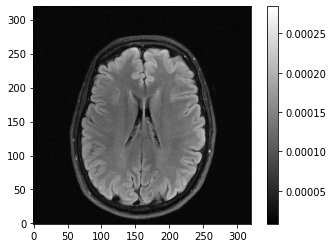

In [5]:
# GT R = 4
plt.imshow(GT[3], cmap='gray', origin='lower')
plt.colorbar()


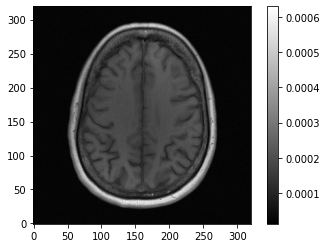

In [14]:
# GT R = 8
plt.imshow(GT[3], cmap='gray', origin='lower')
plt.colorbar()


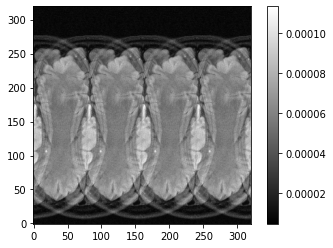

In [7]:
# ZF without ACS R = 4
plt.imshow(reconstruction_ZF_noACS[3], cmap='gray', origin='lower')
plt.colorbar()


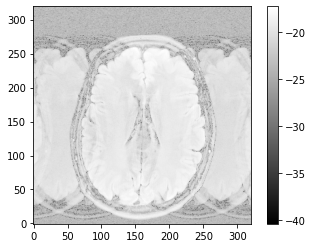

In [8]:
plt.imshow(np.log((GT[3]-reconstruction_ZF_noACS[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [9]:
print(f'NMSE: {nmse(GT,reconstruction_ZF_noACS)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF_noACS)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF_noACS)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF_noACS)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF_noACS)}')


NMSE: 0.39667018829034517
PSNR: 16.331862116579167
SSIM: [0.52590721]
VGG: 0.08940395712852478
SVD: 0.2796875


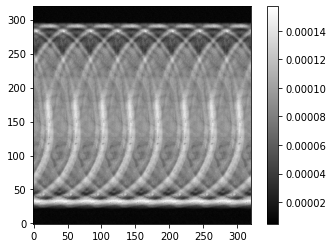

In [15]:
# ZF without ACS R = 8
plt.imshow(reconstruction_ZF_noACS[3], cmap='gray', origin='lower')
plt.colorbar()


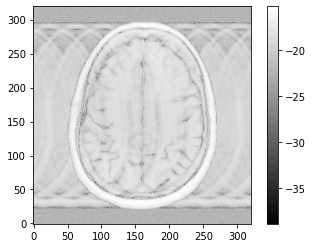

In [16]:
plt.imshow(np.log((GT[3]-reconstruction_ZF_noACS[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [17]:
print(f'NMSE: {nmse(GT,reconstruction_ZF_noACS)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF_noACS)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF_noACS)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF_noACS)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF_noACS)}')


NMSE: 0.5001855514219706
PSNR: 17.114801168683172
SSIM: [0.48308922]
VGG: 0.12611913681030273
SVD: 0.20625


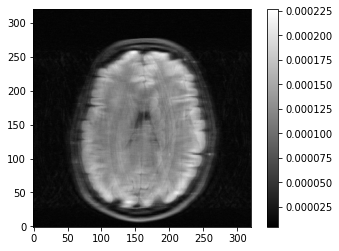

In [8]:
# ZF R = 4
plt.imshow(reconstruction_ZF[3], cmap='gray', origin='lower')
plt.colorbar()


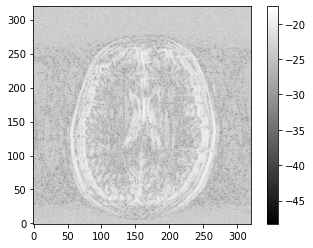

In [11]:
plt.imshow(np.log((GT[3]-reconstruction_ZF[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [27]:
print(f'NMSE: {nmse(GT,reconstruction_ZF)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF)}')


NMSE: 0.03101485738569891
PSNR: 27.4004834072868
SSIM: [0.73984798]
VGG: 0.07876980304718018
SVD: 0.384765625


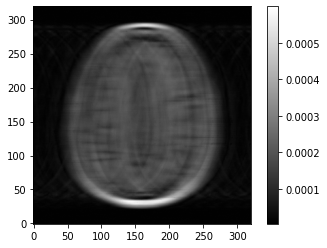

In [18]:
# ZF R = 8
plt.imshow(reconstruction_ZF[3], cmap='gray', origin='lower')
plt.colorbar()


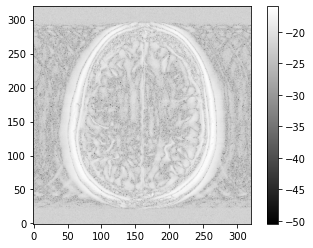

In [19]:
plt.imshow(np.log((GT[3]-reconstruction_ZF[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [20]:
print(f'NMSE: {nmse(GT,reconstruction_ZF)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF)}')


NMSE: 0.07449475023120299
PSNR: 25.384810929048545
SSIM: [0.69789294]
VGG: 0.09795442223548889
SVD: 0.2267578125


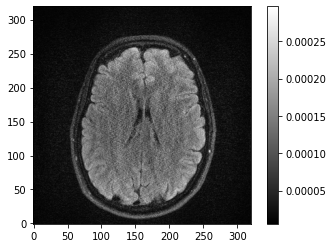

In [10]:
# Grappa R = 4
plt.imshow(reconstruction_grappa[3], cmap='gray', origin='lower')
plt.colorbar()


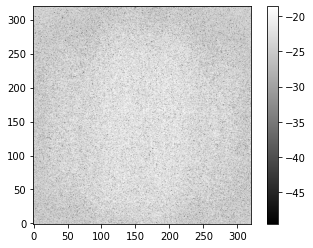

In [12]:
plt.imshow(np.log((GT[3]-reconstruction_grappa[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [28]:
print(f'NMSE: {nmse(GT,reconstruction_grappa)}')
print(f'PSNR: {psnr(GT,reconstruction_grappa)}')
print(f'SSIM: {ssim(GT,reconstruction_grappa)}')
print(f'VGG: {vgg_loss(GT,reconstruction_grappa)}')
print(f'SVD: {stacked_svd(GT,reconstruction_grappa)}')


NMSE: 0.02734263660016758
PSNR: 27.94775389722043
SSIM: [0.67640396]
VGG: 0.045815855264663696
SVD: 0.466796875


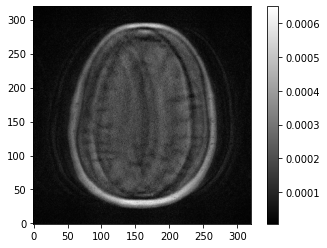

In [21]:
# Grappa R = 8
plt.imshow(reconstruction_grappa[3], cmap='gray', origin='lower')
plt.colorbar()


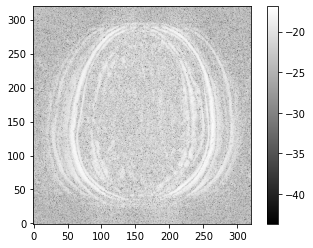

In [22]:
plt.imshow(np.log((GT[3]-reconstruction_grappa[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [23]:
print(f'NMSE: {nmse(GT,reconstruction_grappa)}')
print(f'PSNR: {psnr(GT,reconstruction_grappa)}')
print(f'SSIM: {ssim(GT,reconstruction_grappa)}')
print(f'VGG: {vgg_loss(GT,reconstruction_grappa)}')
print(f'SVD: {stacked_svd(GT,reconstruction_grappa)}')


NMSE: 0.043309225374334556
PSNR: 27.740266096953192
SSIM: [0.68884656]
VGG: 0.0953209400177002
SVD: 0.409375


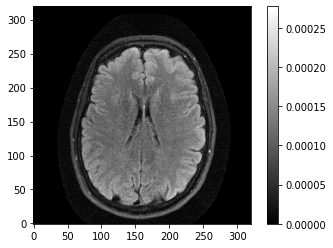

In [13]:
# Sense R = 4
plt.imshow(reconstruction_sense[3], cmap='gray', origin='lower')
plt.colorbar()


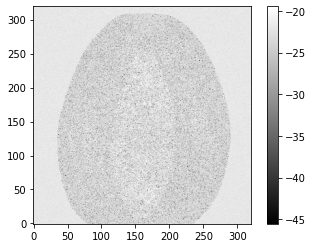

In [14]:
plt.imshow(np.log((GT[3]-reconstruction_sense[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [29]:
print(f'NMSE: {nmse(GT,reconstruction_sense)}')
print(f'PSNR: {psnr(GT,reconstruction_sense)}')
print(f'SSIM: {ssim(GT,reconstruction_sense)}')
print(f'VGG: {vgg_loss(GT,reconstruction_sense)}')
print(f'SVD: {stacked_svd(GT,reconstruction_sense)}')


NMSE: 0.041517476051781424
PSNR: 26.133870393134252
SSIM: [0.40737917]
VGG: 0.03140395134687424
SVD: 0.6134765625


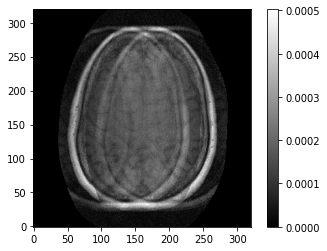

In [24]:
# Sense R = 8
plt.imshow(reconstruction_sense[3], cmap='gray', origin='lower')
plt.colorbar()


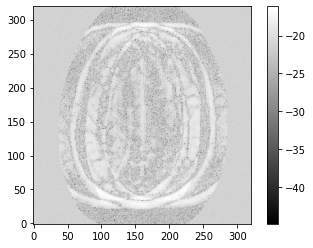

In [25]:
plt.imshow(np.log((GT[3]-reconstruction_sense[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [26]:
print(f'NMSE: {nmse(GT,reconstruction_sense)}')
print(f'PSNR: {psnr(GT,reconstruction_sense)}')
print(f'SSIM: {ssim(GT,reconstruction_sense)}')
print(f'VGG: {vgg_loss(GT,reconstruction_sense)}')
print(f'SVD: {stacked_svd(GT,reconstruction_sense)}')


NMSE: 0.0948047648553698
PSNR: 24.33780908238439
SSIM: [0.34108407]
VGG: 0.12127798795700073
SVD: 0.3599609375


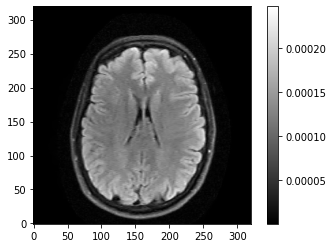

In [15]:
# CS R = 4
plt.imshow(reconstruction_CS[3], cmap='gray', origin='lower')
plt.colorbar()


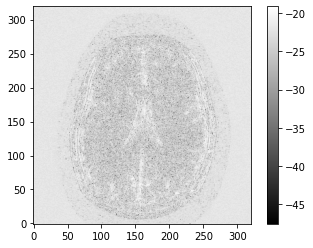

In [16]:
plt.imshow(np.log((GT[3]-reconstruction_CS[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [30]:
print(f'NMSE: {nmse(GT,reconstruction_CS)}')
print(f'PSNR: {psnr(GT,reconstruction_CS)}')
print(f'SSIM: {ssim(GT,reconstruction_CS)}')
print(f'VGG: {vgg_loss(GT,reconstruction_CS)}')
print(f'SVD: {stacked_svd(GT,reconstruction_CS)}')


NMSE: 0.041338441120217985
PSNR: 26.15264147976573
SSIM: [0.41167821]
VGG: 0.028883321210741997
SVD: 0.6115234375


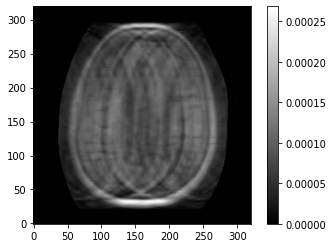

In [27]:
# CS R = 8
plt.imshow(reconstruction_CS[3], cmap='gray', origin='lower')
plt.colorbar()


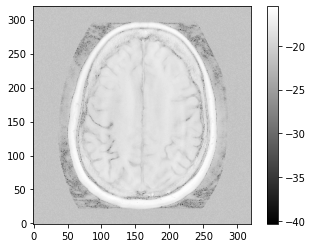

In [28]:
plt.imshow(np.log((GT[3]-reconstruction_CS[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [29]:
print(f'NMSE: {nmse(GT,reconstruction_CS)}')
print(f'PSNR: {psnr(GT,reconstruction_CS)}')
print(f'SSIM: {ssim(GT,reconstruction_CS)}')
print(f'VGG: {vgg_loss(GT,reconstruction_CS)}')
print(f'SVD: {stacked_svd(GT,reconstruction_CS)}')


NMSE: 0.34575639326650737
PSNR: 18.718410020271957
SSIM: [0.27378749]
VGG: 0.1026524156332016
SVD: 0.2232421875


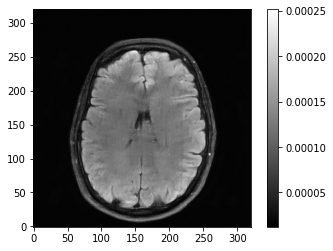

In [17]:
# ZF UNet R = 4
plt.imshow(reconstruction_ZF_unet[3], cmap='gray', origin='lower')
plt.colorbar()


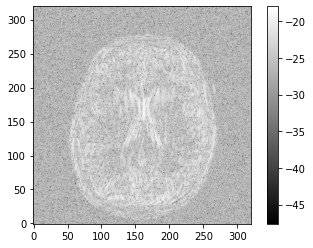

In [18]:
plt.imshow(np.log((GT[3]-reconstruction_ZF_unet[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [31]:
print(f'NMSE: {nmse(GT,reconstruction_ZF_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF_unet)}')


NMSE: 0.009416585760327997
PSNR: 32.577185489713784
SSIM: [0.87611381]
VGG: 0.033087730407714844
SVD: 0.40703125


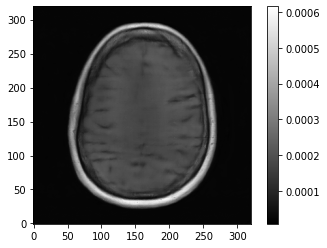

In [30]:
# ZF UNet R = 8
plt.imshow(reconstruction_ZF_unet[3], cmap='gray', origin='lower')
plt.colorbar()


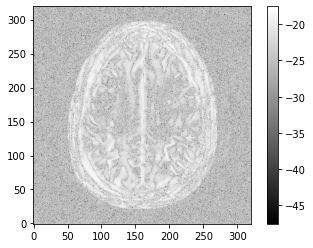

In [31]:
plt.imshow(np.log((GT[3]-reconstruction_ZF_unet[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [32]:
print(f'NMSE: {nmse(GT,reconstruction_ZF_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF_unet)}')


NMSE: 0.014472450059173178
PSNR: 32.500631183713416
SSIM: [0.89889431]
VGG: 0.08050068467855453
SVD: 0.3591796875


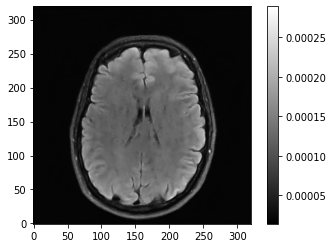

In [19]:
# Grappa UNet R = 4
plt.imshow(reconstruction_grappa_unet[3], cmap='gray', origin='lower')
plt.colorbar()


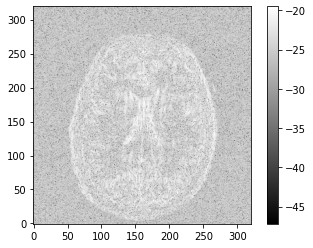

In [20]:
plt.imshow(np.log((GT[3]-reconstruction_grappa_unet[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [32]:
print(f'NMSE: {nmse(GT,reconstruction_grappa_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_grappa_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_grappa_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_grappa_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_grappa_unet)}')


NMSE: 0.009403098362594979
PSNR: 32.583445205648246
SSIM: [0.8684531]
VGG: 0.03477662429213524
SVD: 0.4568359375


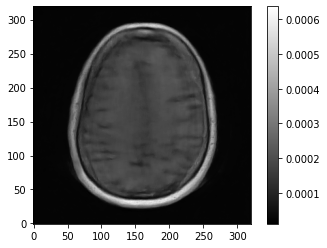

In [33]:
# Grappa UNet R = 8
plt.imshow(reconstruction_grappa_unet[3], cmap='gray', origin='lower')
plt.colorbar()


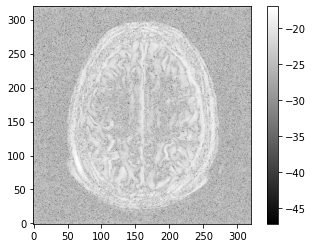

In [34]:
plt.imshow(np.log((GT[3]-reconstruction_grappa_unet[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [35]:
print(f'NMSE: {nmse(GT,reconstruction_grappa_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_grappa_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_grappa_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_grappa_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_grappa_unet)}')


NMSE: 0.014918739187417604
PSNR: 32.36875233668273
SSIM: [0.88215316]
VGG: 0.08329743891954422
SVD: 0.3705078125


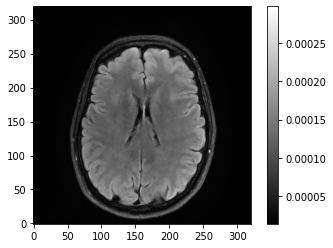

In [21]:
# Sense UNet R = 4
plt.imshow(reconstruction_sense_unet[3], cmap='gray', origin='lower')
plt.colorbar()


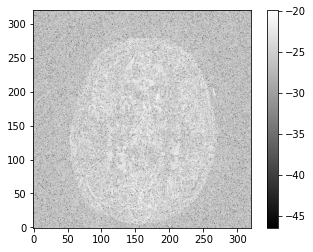

In [22]:
plt.imshow(np.log((GT[3]-reconstruction_sense_unet[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [33]:
print(f'NMSE: {nmse(GT,reconstruction_sense_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_sense_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_sense_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_sense_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_sense_unet)}')


NMSE: 0.005217220386084578
PSNR: 35.14175723292707
SSIM: [0.89877365]
VGG: 0.023584965616464615
SVD: 0.5009765625


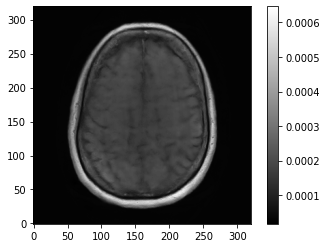

In [36]:
# Sense UNet R = 8
plt.imshow(reconstruction_sense_unet[3], cmap='gray', origin='lower')
plt.colorbar()


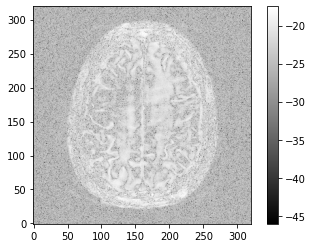

In [37]:
plt.imshow(np.log((GT[3]-reconstruction_sense_unet[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [38]:
print(f'NMSE: {nmse(GT,reconstruction_sense_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_sense_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_sense_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_sense_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_sense_unet)}')


NMSE: 0.015110073851512557
PSNR: 32.3133875183772
SSIM: [0.90436623]
VGG: 0.07027777284383774
SVD: 0.352734375


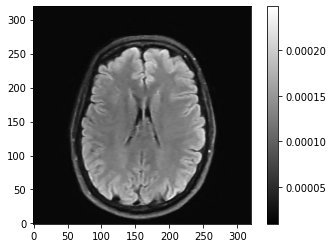

In [23]:
# CS UNet R = 4
plt.imshow(reconstruction_cs_unet[3], cmap='gray', origin='lower')
plt.colorbar()


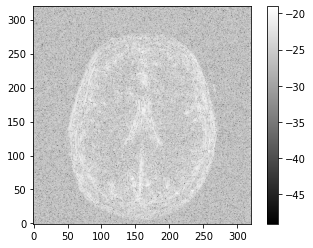

In [24]:
plt.imshow(np.log((GT[3]-reconstruction_cs_unet[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [34]:
print(f'NMSE: {nmse(GT,reconstruction_cs_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_cs_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_cs_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_cs_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_cs_unet)}')


NMSE: 0.008185994324741944
PSNR: 33.18544586437697
SSIM: [0.87798799]
VGG: 0.033498577773571014
SVD: 0.44453125


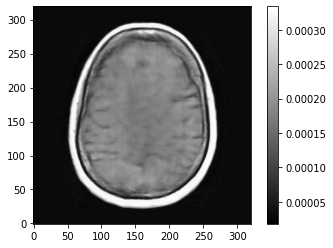

In [39]:
# CS UNet R = 8
plt.imshow(reconstruction_cs_unet[3], cmap='gray', origin='lower')
plt.colorbar()


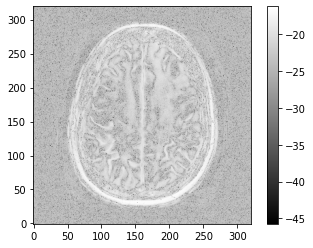

In [40]:
plt.imshow(np.log((GT[3]-reconstruction_cs_unet[3])**2), cmap='gray', origin='lower')
plt.colorbar()


In [41]:
print(f'NMSE: {nmse(GT,reconstruction_cs_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_cs_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_cs_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_cs_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_cs_unet)}')


NMSE: 0.04896172196011893
PSNR: 27.207450045179332
SSIM: [0.86782045]
VGG: 0.09041064977645874
SVD: 0.2287109375
